<a href="https://colab.research.google.com/github/DipankarJDutta/Predicting-Protein-Structures-with-Alphafold-by-Deepmind-/blob/main/AlphaFold_Umps_short.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlphaFold Colab

This Colab notebook allows you to easily predict the structure of a protein using a slightly simplified version of [AlphaFold v2.0](https://doi.org/10.1038/s41586-021-03819-2). 

**Differences to AlphaFold v2.0**

In comparison to AlphaFold v2.0, this Colab notebook uses **no templates (homologous structures)** and a selected portion of the [BFD database](https://bfd.mmseqs.com/). We have validated these changes on several thousand recent PDB structures. While accuracy will be near-identical to the full AlphaFold system on many targets, a small fraction have a large drop in accuracy due to the smaller MSA and lack of templates. For best reliability, we recommend instead using the [full open source AlphaFold](https://github.com/deepmind/alphafold/), or the [AlphaFold Protein Structure Database](https://alphafold.ebi.ac.uk/).

Please note that this Colab notebook is provided as an early-access prototype and is not a finished product. It is provided for theoretical modelling only and caution should be exercised in its use. 

**Citing this work**

Any publication that discloses findings arising from using this notebook should [cite](https://github.com/deepmind/alphafold/#citing-this-work) the [AlphaFold paper](https://doi.org/10.1038/s41586-021-03819-2).

**Licenses**

This Colab uses the [AlphaFold model parameters](https://github.com/deepmind/alphafold/#model-parameters-license) and its outputs are thus for non-commercial use only, under the Creative Commons Attribution-NonCommercial 4.0 International ([CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/legalcode)) license. The Colab itself is provided under the [Apache 2.0 license](https://www.apache.org/licenses/LICENSE-2.0). See the full license statement below.

**More information**

You can find more information about how AlphaFold works in our two Nature papers:

*   [AlphaFold methods paper](https://www.nature.com/articles/s41586-021-03819-2)
*   [AlphaFold predictions of the human proteome paper](https://www.nature.com/articles/s41586-021-03828-1)

FAQ on how to interpret AlphaFold predictions are [here](https://alphafold.ebi.ac.uk/faq).

In [1]:
#@title Install third-party software

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left to download and import third-party software 
#@markdown in this Colab notebook. (See the [acknowledgements](https://github.com/deepmind/alphafold/#acknowledgements) in our readme.)

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      # Uninstall default Colab version of TF.
      %shell pip uninstall -y tensorflow

      %shell sudo apt install --quiet --yes hmmer
      pbar.update(6)

      # Install py3dmol.
      %shell pip install py3dmol
      pbar.update(2)

      # Install OpenMM and pdbfixer.
      %shell rm -rf /opt/conda
      %shell wget -q -P /tmp \
        https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh \
          && bash /tmp/Miniconda3-latest-Linux-x86_64.sh -b -p /opt/conda \
          && rm /tmp/Miniconda3-latest-Linux-x86_64.sh
      pbar.update(9)

      PATH=%env PATH
      %env PATH=/opt/conda/bin:{PATH}
      %shell conda update -qy conda \
          && conda install -qy -c conda-forge \
            python=3.7 \
            openmm=7.5.1 \
            pdbfixer
      pbar.update(80)

      # Create a ramdisk to store a database chunk to make Jackhmmer run fast.
      %shell sudo mkdir -m 777 --parents /tmp/ramdisk
      %shell sudo mount -t tmpfs -o size=9G ramdisk /tmp/ramdisk
      pbar.update(2)

      %shell wget -q -P /content \
        https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
      pbar.update(1)
except subprocess.CalledProcessError:
  print(captured)
  raise

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

In [2]:
#@title Download AlphaFold

#@markdown Please execute this cell by pressing the *Play* button on 
#@markdown the left.

GIT_REPO = 'https://github.com/deepmind/alphafold'

SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar'
PARAMS_DIR = './alphafold/data/params'
PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      %shell rm -rf alphafold
      %shell git clone {GIT_REPO} alphafold
      pbar.update(8)
      # Install the required versions of all dependencies.
      %shell pip3 install -r ./alphafold/requirements.txt
      # Run setup.py to install only AlphaFold.
      %shell pip3 install --no-dependencies ./alphafold
      pbar.update(10)

      # Apply OpenMM patch.
      %shell pushd /opt/conda/lib/python3.7/site-packages/ && \
          patch -p0 < /content/alphafold/docker/openmm.patch && \
          popd
          
      %shell mkdir -p /content/alphafold/common
      %shell cp -f /content/stereo_chemical_props.txt /content/alphafold/common

      %shell mkdir --parents "{PARAMS_DIR}"
      %shell wget -O "{PARAMS_PATH}" "{SOURCE_URL}"
      pbar.update(27)

      %shell tar --extract --verbose --file="{PARAMS_PATH}" \
        --directory="{PARAMS_DIR}" --preserve-permissions
      %shell rm "{PARAMS_PATH}"
      pbar.update(55)
except subprocess.CalledProcessError:
  print(captured)
  raise

import jax
if jax.local_devices()[0].platform == 'tpu':
  raise RuntimeError('Colab TPU runtime not supported. Change it to GPU via Runtime -> Change Runtime Type -> Hardware accelerator -> GPU.')
elif jax.local_devices()[0].platform == 'cpu':
  raise RuntimeError('Colab CPU runtime not supported. Change it to GPU via Runtime -> Change Runtime Type -> Hardware accelerator -> GPU.')

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

## Making a prediction

Please paste the sequence of your protein in the text box below, then run the remaining cells via _Runtime_ > _Run after_. You can also run the cells individually by pressing the _Play_ button on the left.

Note that the search against databases and the actual prediction can take some time, from minutes to hours, depending on the length of the protein and what type of GPU you are allocated by Colab (see FAQ below).

In [3]:
#@title Enter the amino acid sequence to fold ⬇️
sequence = 'MEVASQALGPLVTELYDVQAFKFGSFVLKSGLSSPVYIDLRGIVSRPRLLSQVPSAL'  #@param {type:"string"}

MIN_SEQUENCE_LENGTH = 16
MAX_SEQUENCE_LENGTH = 2500

# Remove all whitespaces, tabs and end lines; upper-case
sequence = sequence.translate(str.maketrans('', '', ' \n\t')).upper()
aatypes = set('ACDEFGHIKLMNPQRSTVWY')  # 20 standard aatypes
if not set(sequence).issubset(aatypes):
  raise Exception(f'Input sequence contains non-amino acid letters: {set(sequence) - aatypes}. AlphaFold only supports 20 standard amino acids as inputs.')
if len(sequence) < MIN_SEQUENCE_LENGTH:
  raise Exception(f'Input sequence is too short: {len(sequence)} amino acids, while the minimum is {MIN_SEQUENCE_LENGTH}')
if len(sequence) > MAX_SEQUENCE_LENGTH:
  raise Exception(f'Input sequence is too long: {len(sequence)} amino acids, while the maximum is {MAX_SEQUENCE_LENGTH}. Please use the full AlphaFold system for long sequences.')

  0%|          | 0/147 [elapsed: 00:00 remaining: ?]

867 Sequences Found in uniref90
69 Sequences Found in smallbfd
405 Sequences Found in mgnify

1294 Sequences Found in Total



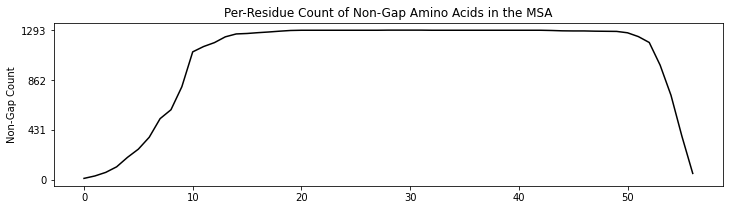

In [4]:
#@title Search against genetic databases

#@markdown Once this cell has been executed, you will see
#@markdown statistics about the multiple sequence alignment 
#@markdown (MSA) that will be used by AlphaFold. In particular, 
#@markdown you’ll see how well each residue is covered by similar 
#@markdown sequences in the MSA.

# --- Python imports ---
import sys
sys.path.append('/opt/conda/lib/python3.7/site-packages')

import os
os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '2.0'

from urllib import request
from concurrent import futures
from google.colab import files
import json
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol

from alphafold.model import model
from alphafold.model import config
from alphafold.model import data

from alphafold.data import parsers
from alphafold.data import pipeline
from alphafold.data.tools import jackhmmer

from alphafold.common import protein

from alphafold.relax import relax
from alphafold.relax import utils

from IPython import display
from ipywidgets import GridspecLayout
from ipywidgets import Output

# Color bands for visualizing plddt
PLDDT_BANDS = [(0, 50, '#FF7D45'),
               (50, 70, '#FFDB13'),
               (70, 90, '#65CBF3'),
               (90, 100, '#0053D6')]

# --- Find the closest source ---
test_url_pattern = 'https://storage.googleapis.com/alphafold-colab{:s}/latest/uniref90_2021_03.fasta.1'
ex = futures.ThreadPoolExecutor(3)
def fetch(source):
  request.urlretrieve(test_url_pattern.format(source))
  return source
fs = [ex.submit(fetch, source) for source in ['', '-europe', '-asia']]
source = None
for f in futures.as_completed(fs):
  source = f.result()
  ex.shutdown()
  break

# --- Search against genetic databases ---
with open('target.fasta', 'wt') as f:
  f.write(f'>query\n{sequence}')

# Run the search against chunks of genetic databases (since the genetic
# databases don't fit in Colab ramdisk).

jackhmmer_binary_path = '/usr/bin/jackhmmer'
dbs = []

num_jackhmmer_chunks = {'uniref90': 59, 'smallbfd': 17, 'mgnify': 71}
total_jackhmmer_chunks = sum(num_jackhmmer_chunks.values())
with tqdm.notebook.tqdm(total=total_jackhmmer_chunks, bar_format=TQDM_BAR_FORMAT) as pbar:
  def jackhmmer_chunk_callback(i):
    pbar.update(n=1)

  pbar.set_description('Searching uniref90')
  jackhmmer_uniref90_runner = jackhmmer.Jackhmmer(
      binary_path=jackhmmer_binary_path,
      database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/uniref90_2021_03.fasta',
      get_tblout=True,
      num_streamed_chunks=num_jackhmmer_chunks['uniref90'],
      streaming_callback=jackhmmer_chunk_callback,
      z_value=135301051)
  dbs.append(('uniref90', jackhmmer_uniref90_runner.query('target.fasta')))

  pbar.set_description('Searching smallbfd')
  jackhmmer_smallbfd_runner = jackhmmer.Jackhmmer(
      binary_path=jackhmmer_binary_path,
      database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/bfd-first_non_consensus_sequences.fasta',
      get_tblout=True,
      num_streamed_chunks=num_jackhmmer_chunks['smallbfd'],
      streaming_callback=jackhmmer_chunk_callback,
      z_value=65984053)
  dbs.append(('smallbfd', jackhmmer_smallbfd_runner.query('target.fasta')))

  pbar.set_description('Searching mgnify')
  jackhmmer_mgnify_runner = jackhmmer.Jackhmmer(
      binary_path=jackhmmer_binary_path,
      database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/mgy_clusters_2019_05.fasta',
      get_tblout=True,
      num_streamed_chunks=num_jackhmmer_chunks['mgnify'],
      streaming_callback=jackhmmer_chunk_callback,
      z_value=304820129)
  dbs.append(('mgnify', jackhmmer_mgnify_runner.query('target.fasta')))


# --- Extract the MSAs and visualize ---
# Extract the MSAs from the Stockholm files.
# NB: deduplication happens later in pipeline.make_msa_features.

mgnify_max_hits = 501

msas = []
deletion_matrices = []
full_msa = []
for db_name, db_results in dbs:
  unsorted_results = []
  for i, result in enumerate(db_results):
    msa, deletion_matrix, target_names = parsers.parse_stockholm(result['sto'])
    e_values_dict = parsers.parse_e_values_from_tblout(result['tbl'])
    e_values = [e_values_dict[t.split('/')[0]] for t in target_names]
    zipped_results = zip(msa, deletion_matrix, target_names, e_values)
    if i != 0:
      # Only take query from the first chunk
      zipped_results = [x for x in zipped_results if x[2] != 'query']
    unsorted_results.extend(zipped_results)
  sorted_by_evalue = sorted(unsorted_results, key=lambda x: x[3])
  db_msas, db_deletion_matrices, _, _ = zip(*sorted_by_evalue)
  if db_msas:
    if db_name == 'mgnify':
      db_msas = db_msas[:mgnify_max_hits]
      db_deletion_matrices = db_deletion_matrices[:mgnify_max_hits]
    full_msa.extend(db_msas)
    msas.append(db_msas)
    deletion_matrices.append(db_deletion_matrices)
    msa_size = len(set(db_msas))
    print(f'{msa_size} Sequences Found in {db_name}')

deduped_full_msa = list(dict.fromkeys(full_msa))
total_msa_size = len(deduped_full_msa)
print(f'\n{total_msa_size} Sequences Found in Total\n')

aa_map = {restype: i for i, restype in enumerate('ABCDEFGHIJKLMNOPQRSTUVWXYZ-')}
msa_arr = np.array([[aa_map[aa] for aa in seq] for seq in deduped_full_msa])
num_alignments, num_res = msa_arr.shape

fig = plt.figure(figsize=(12, 3))
plt.title('Per-Residue Count of Non-Gap Amino Acids in the MSA')
plt.plot(np.sum(msa_arr != aa_map['-'], axis=0), color='black')
plt.ylabel('Non-Gap Count')
plt.yticks(range(0, num_alignments + 1, max(1, int(num_alignments / 3))))
plt.show()

  0%|          | 0/7 [elapsed: 00:00 remaining: ?]

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

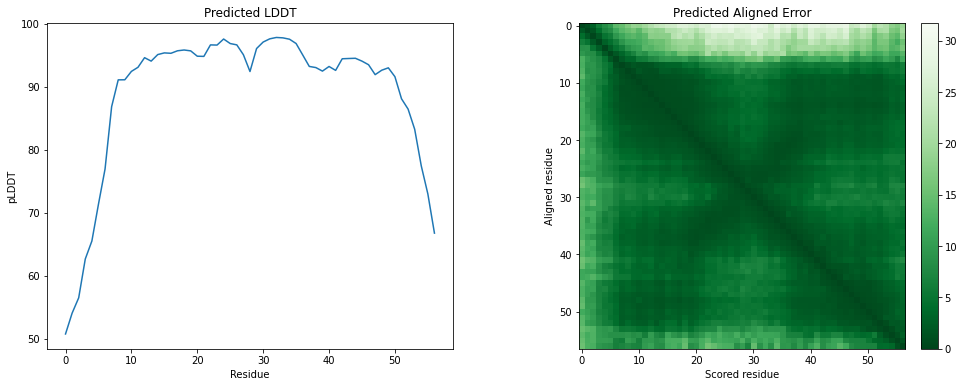

In [5]:
#@title Run AlphaFold and download prediction

#@markdown Once this cell has been executed, a zip-archive with 
#@markdown the obtained prediction will be automatically downloaded 
#@markdown to your computer.

# --- Run the model ---
model_names = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_2_ptm']

def _placeholder_template_feats(num_templates_, num_res_):
  return {
      'template_aatype': np.zeros([num_templates_, num_res_, 22], np.float32),
      'template_all_atom_masks': np.zeros([num_templates_, num_res_, 37, 3], np.float32),
      'template_all_atom_positions': np.zeros([num_templates_, num_res_, 37], np.float32),
      'template_domain_names': np.zeros([num_templates_], np.float32),
      'template_sum_probs': np.zeros([num_templates_], np.float32),
  }

output_dir = 'prediction'
os.makedirs(output_dir, exist_ok=True)

plddts = {}
pae_outputs = {}
unrelaxed_proteins = {}

with tqdm.notebook.tqdm(total=len(model_names) + 1, bar_format=TQDM_BAR_FORMAT) as pbar:
  for model_name in model_names:
    pbar.set_description(f'Running {model_name}')
    num_templates = 0
    num_res = len(sequence)

    feature_dict = {}
    feature_dict.update(pipeline.make_sequence_features(sequence, 'test', num_res))
    feature_dict.update(pipeline.make_msa_features(msas, deletion_matrices=deletion_matrices))
    feature_dict.update(_placeholder_template_feats(num_templates, num_res))

    cfg = config.model_config(model_name)
    params = data.get_model_haiku_params(model_name, './alphafold/data')
    model_runner = model.RunModel(cfg, params)
    processed_feature_dict = model_runner.process_features(feature_dict,
                                                           random_seed=0)
    prediction_result = model_runner.predict(processed_feature_dict)

    mean_plddt = prediction_result['plddt'].mean()

    if 'predicted_aligned_error' in prediction_result:
      pae_outputs[model_name] = (
          prediction_result['predicted_aligned_error'],
          prediction_result['max_predicted_aligned_error']
      )
    else:
      # Get the pLDDT confidence metrics. Do not put pTM models here as they
      # should never get selected.
      plddts[model_name] = prediction_result['plddt']

    # Set the b-factors to the per-residue plddt.
    final_atom_mask = prediction_result['structure_module']['final_atom_mask']
    b_factors = prediction_result['plddt'][:, None] * final_atom_mask
    unrelaxed_protein = protein.from_prediction(processed_feature_dict,
                                                prediction_result,
                                                b_factors=b_factors)
    unrelaxed_proteins[model_name] = unrelaxed_protein

    # Delete unused outputs to save memory.
    del model_runner
    del params
    del prediction_result
    pbar.update(n=1)

  # --- AMBER relax the best model ---
  pbar.set_description(f'AMBER relaxation')
  amber_relaxer = relax.AmberRelaxation(
      max_iterations=0,
      tolerance=2.39,
      stiffness=10.0,
      exclude_residues=[],
      max_outer_iterations=20)
  # Find the best model according to the mean pLDDT.
  best_model_name = max(plddts.keys(), key=lambda x: plddts[x].mean())
  relaxed_pdb, _, _ = amber_relaxer.process(
      prot=unrelaxed_proteins[best_model_name])
  pbar.update(n=1)  # Finished AMBER relax.

# Construct multiclass b-factors to indicate confidence bands
# 0=very low, 1=low, 2=confident, 3=very high
banded_b_factors = []
for plddt in plddts[best_model_name]:
  for idx, (min_val, max_val, _) in enumerate(PLDDT_BANDS):
    if plddt >= min_val and plddt <= max_val:
      banded_b_factors.append(idx)
      break
banded_b_factors = np.array(banded_b_factors)[:, None] * final_atom_mask
to_visualize_pdb = utils.overwrite_b_factors(relaxed_pdb, banded_b_factors)


# Write out the prediction
pred_output_path = os.path.join(output_dir, 'selected_prediction.pdb')
with open(pred_output_path, 'w') as f:
  f.write(relaxed_pdb)


# --- Visualise the prediction & confidence ---
show_sidechains = True
def plot_plddt_legend():
  """Plots the legend for pLDDT."""
  thresh = [
            'Very low (pLDDT < 50)',
            'Low (70 > pLDDT > 50)',
            'Confident (90 > pLDDT > 70)',
            'Very high (pLDDT > 90)']

  colors = [x[2] for x in PLDDT_BANDS]

  plt.figure(figsize=(2, 2))
  for c in colors:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False, loc='center', fontsize=20)
  plt.xticks([])
  plt.yticks([])
  ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  plt.title('Model Confidence', fontsize=20, pad=20)
  return plt

# Color the structure by per-residue pLDDT
color_map = {i: bands[2] for i, bands in enumerate(PLDDT_BANDS)}
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(to_visualize_pdb)
style = {'cartoon': {
    'colorscheme': {
        'prop': 'b',
        'map': color_map}
        }}
if show_sidechains:
  style['stick'] = {}
view.setStyle({'model': -1}, style)
view.zoomTo()

grid = GridspecLayout(1, 2)
out = Output()
with out:
  view.show()
grid[0, 0] = out

out = Output()
with out:
  plot_plddt_legend().show()
grid[0, 1] = out

display.display(grid)

# Display pLDDT and predicted aligned error (if output by the model).
if pae_outputs:
  num_plots = 2
else:
  num_plots = 1

plt.figure(figsize=[8 * num_plots, 6])
plt.subplot(1, num_plots, 1)
plt.plot(plddts[best_model_name])
plt.title('Predicted LDDT')
plt.xlabel('Residue')
plt.ylabel('pLDDT')

if num_plots == 2:
  plt.subplot(1, 2, 2)
  pae, max_pae = list(pae_outputs.values())[0]
  plt.imshow(pae, vmin=0., vmax=max_pae, cmap='Greens_r')
  plt.colorbar(fraction=0.046, pad=0.04)
  plt.title('Predicted Aligned Error')
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

# Save pLDDT and predicted aligned error (if it exists)
pae_output_path = os.path.join(output_dir, 'predicted_aligned_error.json')
if pae_outputs:
  # Save predicted aligned error in the same format as the AF EMBL DB
  rounded_errors = np.round(pae.astype(np.float64), decimals=1)
  indices = np.indices((len(rounded_errors), len(rounded_errors))) + 1
  indices_1 = indices[0].flatten().tolist()
  indices_2 = indices[1].flatten().tolist()
  pae_data = json.dumps([{
      'residue1': indices_1,
      'residue2': indices_2,
      'distance': rounded_errors.flatten().tolist(),
      'max_predicted_aligned_error': max_pae.item()
  }],
                        indent=None,
                        separators=(',', ':'))
  with open(pae_output_path, 'w') as f:
    f.write(pae_data)


# --- Download the predictions ---
!zip -q -r {output_dir}.zip {output_dir}
files.download(f'{output_dir}.zip')

### Interpreting the prediction

Please see the [AlphaFold methods paper](https://www.nature.com/articles/s41586-021-03819-2) and the [AlphaFold predictions of the human proteome paper](https://www.nature.com/articles/s41586-021-03828-1), as well as [our FAQ](https://alphafold.ebi.ac.uk/faq) on how to interpret AlphaFold predictions.

## FAQ & Troubleshooting


*   How do I get a predicted protein structure for my protein?
    *   Click on the _Connect_ button on the top right to get started.
    *   Paste the amino acid sequence of your protein (without any headers) into the “Enter the amino acid sequence to fold”.
    *   Run all cells in the Colab, either by running them individually (with the play button on the left side) or via _Runtime_ > _Run all._
    *   The predicted protein structure will be downloaded once all cells have been executed. Note: This can take minutes to hours - see below.
*   How long will this take?
    *   Downloading the AlphaFold source code can take up to a few minutes.
    *   Downloading and installing the third-party software can take up to a few minutes.
    *   The search against genetic databases can take minutes to hours.
    *   Running AlphaFold and generating the prediction can take minutes to hours, depending on the length of your protein and on which GPU-type Colab has assigned you.
*   My Colab no longer seems to be doing anything, what should I do?
    *   Some steps may take minutes to hours to complete.
    *   If nothing happens or if you receive an error message, try restarting your Colab runtime via _Runtime_ > _Restart runtime_.
    *   If this doesn’t help, try resetting your Colab runtime via _Runtime_ > _Factory reset runtime_.
*   How does this compare to the open-source version of AlphaFold?
    *   This Colab version of AlphaFold searches a selected portion of the BFD dataset and currently doesn’t use templates, so its accuracy is reduced in comparison to the full version of AlphaFold that is described in the [AlphaFold paper](https://doi.org/10.1038/s41586-021-03819-2) and [Github repo](https://github.com/deepmind/alphafold/) (the full version is available via the inference script).
*   What is a Colab?
    *   See the [Colab FAQ](https://research.google.com/colaboratory/faq.html).
*   I received a warning “Notebook requires high RAM”, what do I do?
    *   The resources allocated to your Colab vary. See the [Colab FAQ](https://research.google.com/colaboratory/faq.html) for more details.
    *   You can execute the Colab nonetheless.
*   I received an error “Colab CPU runtime not supported” or “No GPU/TPU found”, what do I do?
    *   Colab CPU runtime is not supported. Try changing your runtime via _Runtime_ > _Change runtime type_ > _Hardware accelerator_ > _GPU_.
    *   The type of GPU allocated to your Colab varies. See the [Colab FAQ](https://research.google.com/colaboratory/faq.html) for more details.
    *   If you receive “Cannot connect to GPU backend”, you can try again later to see if Colab allocates you a GPU.
    *   [Colab Pro](https://colab.research.google.com/signup) offers priority access to GPUs. 
*   Does this tool install anything on my computer?
    *   No, everything happens in the cloud on Google Colab.
    *   At the end of the Colab execution a zip-archive with the obtained prediction will be automatically downloaded to your computer.
*   How should I share feedback and bug reports?
    *   Please share any feedback and bug reports as an [issue](https://github.com/deepmind/alphafold/issues) on Github.


## Related work

Take a look at these Colab notebooks provided by the community (please note that these notebooks may vary from our validated AlphaFold system and we cannot guarantee their accuracy):

*   The [ColabFold AlphaFold2 notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) by Sergey Ovchinnikov, Milot Mirdita and Martin Steinegger, which uses an API hosted at the Södinglab based on the MMseqs2 server ([Mirdita et al. 2019, Bioinformatics](https://academic.oup.com/bioinformatics/article/35/16/2856/5280135)) for the multiple sequence alignment creation.


# License and Disclaimer

This is not an officially-supported Google product.

This Colab notebook and other information provided is for theoretical modelling only, caution should be exercised in its use. It is provided ‘as-is’ without any warranty of any kind, whether expressed or implied. Information is not intended to be a substitute for professional medical advice, diagnosis, or treatment, and does not constitute medical or other professional advice.

Copyright 2021 DeepMind Technologies Limited.


## AlphaFold Code License

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Model Parameters License

The AlphaFold parameters are made available for non-commercial use only, under the terms of the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. You can find details at: https://creativecommons.org/licenses/by-nc/4.0/legalcode


## Third-party software

Use of the third-party software, libraries or code referred to in the [Acknowledgements section](https://github.com/deepmind/alphafold/#acknowledgements) in the AlphaFold README may be governed by separate terms and conditions or license provisions. Your use of the third-party software, libraries or code is subject to any such terms and you should check that you can comply with any applicable restrictions or terms and conditions before use.


## Mirrored Databases

The following databases have been mirrored by DeepMind, and are available with reference to the following:
* UniRef90: v2021\_03 (unmodified), by The UniProt Consortium, available under a [Creative Commons Attribution-NoDerivatives 4.0 International License](http://creativecommons.org/licenses/by-nd/4.0/).
* MGnify: v2019\_05 (unmodified), by Mitchell AL et al., available free of all copyright restrictions and made fully and freely available for both non-commercial and commercial use under [CC0 1.0 Universal (CC0 1.0) Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/).
* BFD: (modified), by Steinegger M. and Söding J., modified by DeepMind, available under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by/4.0/). See the Methods section of the [AlphaFold proteome paper](https://www.nature.com/articles/s41586-021-03828-1) for details.